# **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as T

from tqdm.notebook import tqdm

import time

from sklearn.metrics import classification_report,confusion_matrix

In [2]:
train_dir='/kaggle/input/butterfly-images40-species/train'
valid_dir='/kaggle/input/butterfly-images40-species/valid'
test_dir='/kaggle/input/butterfly-images40-species/test'

# **Data Loader**

In [3]:
# defining transforms
image_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

transforms = {
    "train": T.Compose([
       T.Resize(image_size),
       T.ToTensor(),
       T.Normalize(*imagenet_stats)
    ]),
    "validation": T.Compose([
        T.Resize(image_size),
        T.ToTensor(),
        T.Normalize(*imagenet_stats)
    ]),
    "test": T.Compose([
        T.Resize(image_size),
        T.ToTensor(),
        T.Normalize(*imagenet_stats)
    ])
}

In [4]:
# load train data
train = torchvision.datasets.ImageFolder(train_dir, transform =transforms["train"])
train_loader = DataLoader(train, batch_size=32, shuffle=True)

#load validation data
validation  = torchvision.datasets.ImageFolder(valid_dir, transform =transforms["validation"])
validation_loader = DataLoader(validation, batch_size=32, shuffle=False)

#load test data
test  = torchvision.datasets.ImageFolder(test_dir, transform =transforms["test"])
test_loader = DataLoader(test, batch_size=32, shuffle=False)

In [5]:
classes = train.classes
len_classes = len(classes)

In [6]:
print(len_classes)

100


In [7]:
# Get classes numbers
num_classes = len(train.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 100


In [8]:
images, labels = next(iter(train_loader))
print(labels[:10])

tensor([64, 30, 79, 88, 26, 17,  2, 68, 36, 99])


In [9]:
images, labels = next(iter(validation_loader))
print(labels[:10])

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])


In [10]:
images, labels = next(iter(test_loader))
print(labels[:10])

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])


# **Data Visualization**

In [11]:
# function to denormalize
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

# to show the images
def show_images(img,label):
    plt.figure(figsize = [20,14])
    for i in range(25):
        plt.subplot(5,5,i+1)
        img[i] = denormalize(img[i], *imagenet_stats)
        plt.imshow(img[i].permute(1,2,0))
        plt.title(classes[label[i]])
        plt.axis("off")
    plt.show()

In [12]:
# one batch 
images,labels = next(iter(train_loader))
print(images.shape)

torch.Size([32, 3, 224, 224])


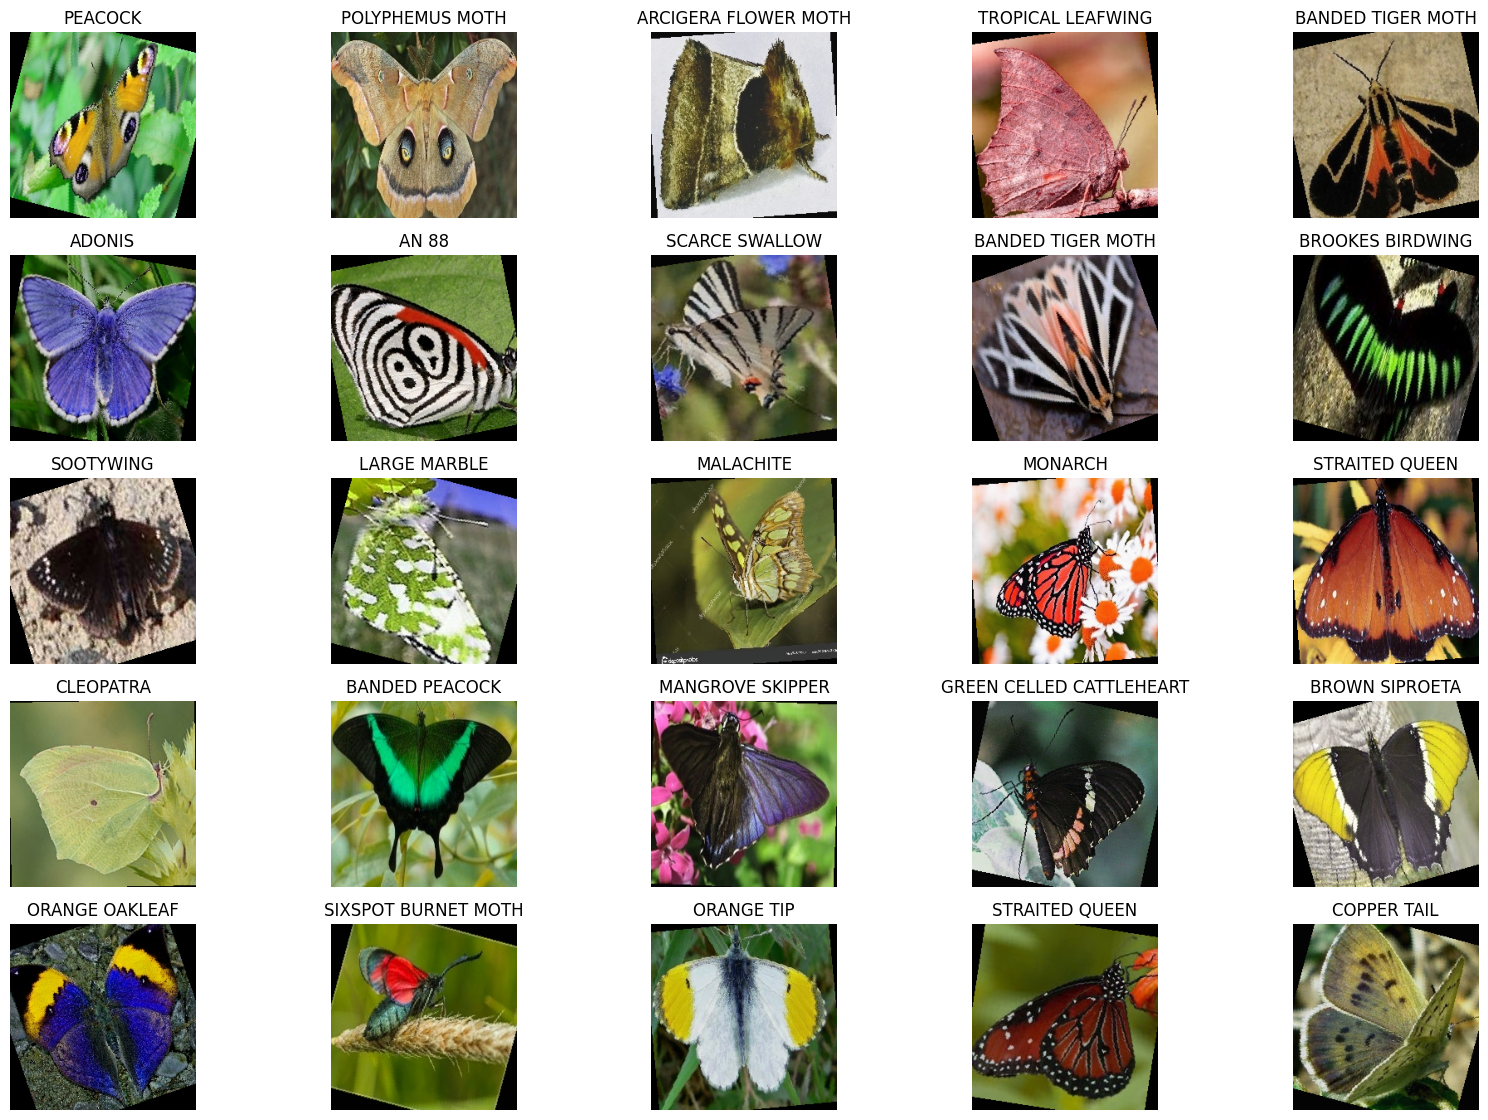

In [13]:
# show the images
show_images(images,labels)

# **Simple Model Architecture**

**Model Architecture**

The model consists of:

- **Four convolutional layers**, which extract different features like edges, textures, and object parts.
    
- **Batch normalization** to stabilize training and speed up convergence.
    
- **ReLU activation function**, introducing non-linearity to enhance feature learning.
    
- **Max pooling layers**, which reduce the spatial dimensions while retaining important information.
    
- **Two fully connected layers**, where the first one (with 1024 neurons) helps in feature abstraction, and the second one outputs probabilities for 100 classes."

📌 **Flow of the model**:

➡ Input Image → Convolution → ReLU → Pooling → More Convolution & Pooling → Flatten → Fully Connected Layers → Output (Predicted Class)

In [19]:
class Model(nn.Module):
    def __init__(self, num_classes=100):
        super(Model, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        
        # Fully connected layers
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)  
        #self.dropout = nn.Dropout(0.3)  # Dropout for regularization
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        
        # Flatten the output for fully connected layers
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.relu(self.fc1(x))
        #x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [20]:
# Instantiate the model
Mymodel = Model() 

In [15]:
def train_model(model, train_loader, validation_loader, criterion, optimizer, epochs=5):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        correct, total = 0, 0
        running_train_loss = 0.0  # Track total training loss

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_train_loss += loss.item()  # Accumulate loss

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # Compute average training loss & accuracy
        train_loss = running_train_loss / len(train_loader)
        train_acc = correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Validation phase
        model.eval()
        correct, total = 0, 0
        running_val_loss = 0.0  # Track total validation loss

        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()  # Accumulate loss

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        # Compute average validation loss & accuracy
        val_loss = running_val_loss / len(validation_loader)
        val_acc = correct / total
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [16]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f}")

In [21]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Mymodel.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Mymodel.parameters(), lr=0.001)

In [24]:
# Train and validate model
train_loss_history1, train_acc_history1, val_loss_history1, val_acc_history1 =train_model(Mymodel, train_loader, validation_loader, criterion, optimizer, epochs=20)

Epoch 1/20 - Train Loss: 1.4030, Train Acc: 0.5834, Val Loss: 1.4838, Val Acc: 0.5600
Epoch 2/20 - Train Loss: 1.2469, Train Acc: 0.6254, Val Loss: 1.5676, Val Acc: 0.5820
Epoch 3/20 - Train Loss: 1.1119, Train Acc: 0.6594, Val Loss: 1.4151, Val Acc: 0.6160
Epoch 4/20 - Train Loss: 0.9472, Train Acc: 0.7029, Val Loss: 1.4592, Val Acc: 0.6020
Epoch 5/20 - Train Loss: 0.8301, Train Acc: 0.7369, Val Loss: 1.6760, Val Acc: 0.6000
Epoch 6/20 - Train Loss: 0.7026, Train Acc: 0.7711, Val Loss: 1.6120, Val Acc: 0.6140
Epoch 7/20 - Train Loss: 0.5882, Train Acc: 0.8109, Val Loss: 1.4857, Val Acc: 0.6500
Epoch 8/20 - Train Loss: 0.4746, Train Acc: 0.8472, Val Loss: 1.4450, Val Acc: 0.6440
Epoch 9/20 - Train Loss: 0.4236, Train Acc: 0.8618, Val Loss: 1.6120, Val Acc: 0.6300
Epoch 10/20 - Train Loss: 0.3249, Train Acc: 0.8936, Val Loss: 1.7457, Val Acc: 0.6260
Epoch 11/20 - Train Loss: 0.2890, Train Acc: 0.9042, Val Loss: 1.6735, Val Acc: 0.6620
Epoch 12/20 - Train Loss: 0.2881, Train Acc: 0.9050,

In [25]:
# Evaluate the trained model
model=evaluate_model(Mymodel, test_loader)

Test Accuracy: 0.6720


# **ResNet50 Model**

In [19]:
model_resnet50 = models.resnet50(pretrained=True)

# Modify the fully connected layer to match the number of classes
model_resnet50.fc = nn.Linear(model_resnet50.fc.in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet50.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet50.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 222MB/s]


## **ResNet50: Training Phase**

In [21]:
# Train for 10 epochs
train_loss_history, train_acc_history, val_loss_history, val_acc_history= train_model(model_resnet50, train_loader, validation_loader, criterion, optimizer, epochs=10)

Epoch 1/10 - Train Loss: 3.5071, Train Acc: 0.1578, Val Loss: 2.5978, Val Acc: 0.2940
Epoch 2/10 - Train Loss: 1.6957, Train Acc: 0.5239, Val Loss: 1.4684, Val Acc: 0.5880
Epoch 3/10 - Train Loss: 1.0709, Train Acc: 0.6962, Val Loss: 1.1022, Val Acc: 0.6980
Epoch 4/10 - Train Loss: 0.8119, Train Acc: 0.7700, Val Loss: 0.5813, Val Acc: 0.8260
Epoch 5/10 - Train Loss: 0.6533, Train Acc: 0.8125, Val Loss: 0.6104, Val Acc: 0.8120
Epoch 6/10 - Train Loss: 0.5512, Train Acc: 0.8339, Val Loss: 0.5285, Val Acc: 0.8380
Epoch 7/10 - Train Loss: 0.4764, Train Acc: 0.8646, Val Loss: 0.4162, Val Acc: 0.8760
Epoch 8/10 - Train Loss: 0.4387, Train Acc: 0.8722, Val Loss: 0.4358, Val Acc: 0.8720
Epoch 9/10 - Train Loss: 0.3724, Train Acc: 0.8910, Val Loss: 0.4589, Val Acc: 0.8520
Epoch 10/10 - Train Loss: 0.3436, Train Acc: 0.9008, Val Loss: 0.3448, Val Acc: 0.9140


## **ResNet50: Evaluation Phase**

In [22]:
# Evaluate the trained model
model_resnet50=evaluate_model(model_resnet50, test_loader)

Test Accuracy: 0.9220


## **ResNet50: Visualize Results**

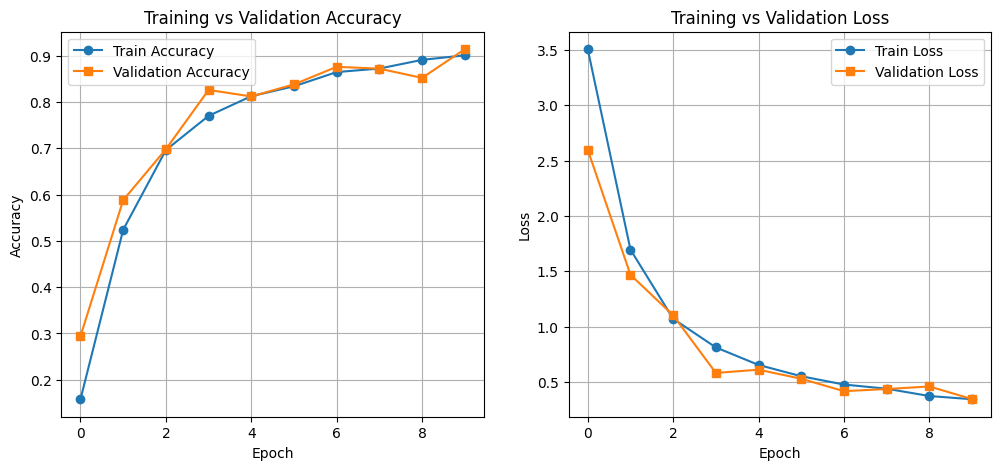

In [23]:
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # First subplot
plt.plot(train_acc_history, label="Train Accuracy", marker="o")
plt.plot(val_acc_history, label="Validation Accuracy", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)  # Second subplot
plt.plot(train_loss_history, label="Train Loss", marker="o")
plt.plot(val_loss_history, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.show()


# **EfficientNet Model**

In [24]:
# Load EfficientNet model
model_efficientnet = models.efficientnet_b0(pretrained=True)  

# Modify the classifier layer to match the number of classes
model_efficientnet.classifier[1] = nn.Linear(model_efficientnet.classifier[1].in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_efficientnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_efficientnet.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 152MB/s]


## **EfficientNet: Training Phase**

In [26]:
# Train for 5 epochs
train_loss_history2, train_acc_history2, val_loss_history2, val_acc_history2= train_model(model_efficientnet, train_loader, validation_loader, criterion, optimizer, epochs=5)

Epoch 1/5 - Train Loss: 0.2913, Train Acc: 0.9147, Val Loss: 0.2819, Val Acc: 0.9420
Epoch 2/5 - Train Loss: 0.2442, Train Acc: 0.9302, Val Loss: 0.2314, Val Acc: 0.9380
Epoch 3/5 - Train Loss: 0.2034, Train Acc: 0.9407, Val Loss: 0.2823, Val Acc: 0.9340
Epoch 4/5 - Train Loss: 0.1835, Train Acc: 0.9432, Val Loss: 0.2522, Val Acc: 0.9400
Epoch 5/5 - Train Loss: 0.1841, Train Acc: 0.9417, Val Loss: 0.3639, Val Acc: 0.9280


## **EfficientNet: Evaluation Phase**

In [27]:
# Evaluate the trained model
model_resnet50=evaluate_model(model_efficientnet, test_loader)

Test Accuracy: 0.9460


## **EfficientNet: Visualize Results**

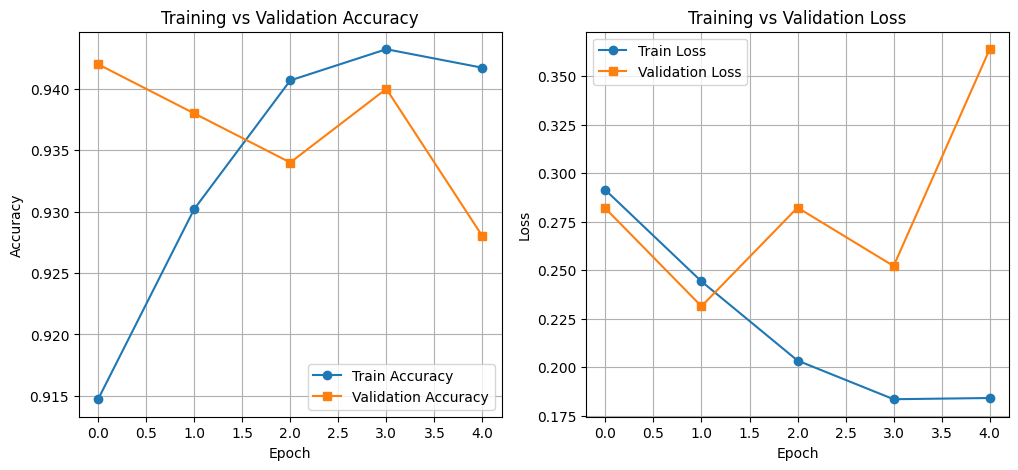

In [28]:
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # First subplot
plt.plot(train_acc_history2, label="Train Accuracy", marker="o")
plt.plot(val_acc_history2, label="Validation Accuracy", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)  # Second subplot
plt.plot(train_loss_history2, label="Train Loss", marker="o")
plt.plot(val_loss_history2, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.show()

 # **DenseNet model**

In [29]:
# Load DenseNet model
model_densenet = models.densenet121(pretrained=True)  

# Modify the classifier layer to match the number of classes
model_densenet.classifier = nn.Linear(model_densenet.classifier.in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_densenet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_densenet.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 151MB/s]


## **DenseNet: Training Phase**

In [30]:
# Train for 5 epochs
train_loss_history3, train_acc_history3, val_loss_history3, val_acc_history3= train_model(model_densenet, train_loader, validation_loader, criterion, optimizer, epochs=5)

Epoch 1/5 - Train Loss: 1.2629, Train Acc: 0.6879, Val Loss: 0.4956, Val Acc: 0.8660
Epoch 2/5 - Train Loss: 0.4987, Train Acc: 0.8597, Val Loss: 0.3819, Val Acc: 0.8960
Epoch 3/5 - Train Loss: 0.3902, Train Acc: 0.8851, Val Loss: 0.3046, Val Acc: 0.9200
Epoch 4/5 - Train Loss: 0.3075, Train Acc: 0.9079, Val Loss: 0.3069, Val Acc: 0.9200
Epoch 5/5 - Train Loss: 0.2746, Train Acc: 0.9150, Val Loss: 0.2770, Val Acc: 0.9120


## **DenseNet: Evaluation Phase**

In [31]:
# Evaluate the trained model
model_densenet_test=evaluate_model(model_densenet, test_loader)

Test Accuracy: 0.9340


## **DenseNet: Visualize Results**

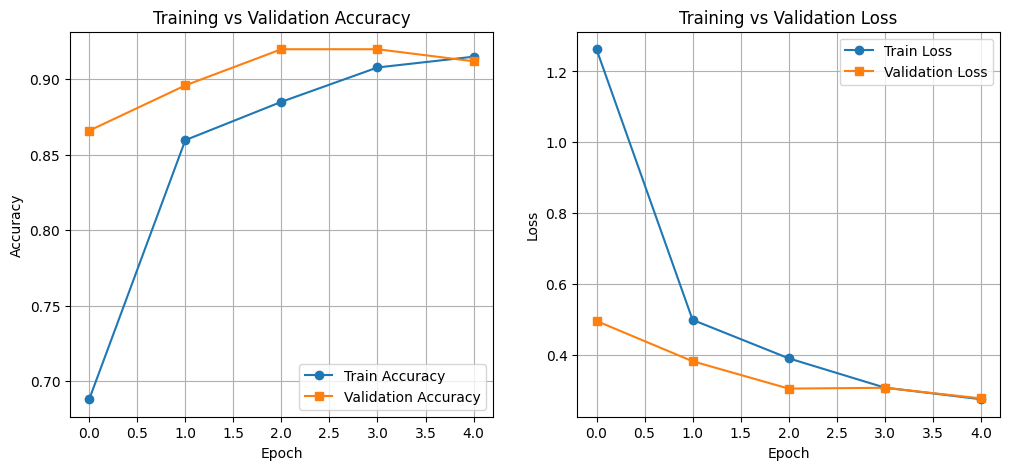

In [32]:
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # First subplot
plt.plot(train_acc_history3, label="Train Accuracy", marker="o")
plt.plot(val_acc_history3, label="Validation Accuracy", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)  # Second subplot
plt.plot(train_loss_history3, label="Train Loss", marker="o")
plt.plot(val_loss_history3, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.show()

<Axes: xlabel='models', ylabel='training loss'>

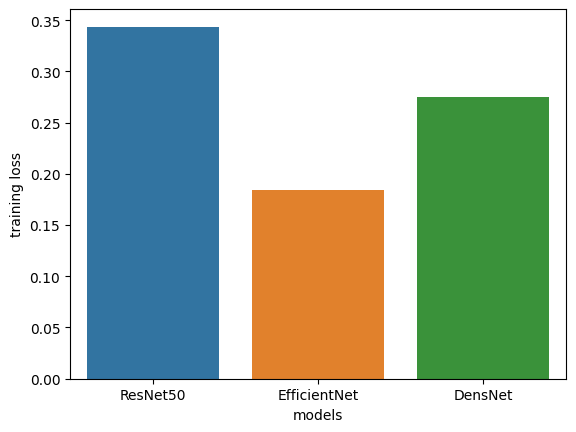

In [55]:
model = {
    'models': ['ResNet50', 'EfficientNet', 'DensNet'],
    'training loss': [history[-1] for history in [train_loss_history, train_loss_history2, train_loss_history3]]
}

model_df = pd.DataFrame(model)
sns.barplot(x='models',y='training loss',data=model_df)